# General

## Dataset
https://www.kaggle.com/datasets/blastchar/telco-customer-churn

# TODO:
### David:
- pre-processing
  - Compute average for TotalColumns & fill in
  - feature scaling (standardize or normalize ?)
  - mapping
  - export processed csv to Tim
- feature selection
- performance visualization


### Ideas for the final report.  What is the goal of our final project?

Primary

* Make RandomForestClassifier work and figure out how to optimize its predictive performance.
* Show that it performs better than other algorithms.

Secondary

* Focus it more on understanding why an ML algorithm performs better
* (Overfitting, high correlation, other pitfalls of ML algorithms)?

In [2]:
## Imports & Settings
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skm

# display all columns and rows:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

<h1 style='color:orange'>NOTE</h1>

### Breiman (2001) Section 5:

* If, after feature selection, it is found that only a handful of features are actually any good, Breiman seems to suggest combining these features into some additional features for datasets with fewer than 3000 instances.  See paper for implementation.

### Section 5.1:

* Breiman on handling non-binary categorical variables when forming combined features.

In [3]:
## Dataset & Preprocessing

# Dataset
df_original = pd.read_csv('dataset/telco-customer-churn.csv', index_col=0)
df = df_original.copy()

# Label Encoding (converting categorical to numerical)
categorical_columns = [
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines','InternetService',
    'OnlineSecurity', 'OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
    'StreamingMovies','Contract','PaperlessBilling','PaymentMethod', 'Churn'
]

# convert and replace categorical columns with numerical data
# encoding is done with categorical labels that sorted alphabetically so df = ['c','z','a'] will always encode to [1,2,0]
for col in categorical_columns:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

# Dataframe where rows with blank TotalCharges ' ' replaced with 0
df_0 = df.copy()
df_0['TotalCharges'].replace(" ", 0, inplace=True)
df_0['TotalCharges'] = df_0['TotalCharges'].astype(float)

# Dataframe where rows with blank TotalCharges ' ' are deleted
df_d = df.copy()
df_d.drop(df_d[df_d.TotalCharges == " "].index, inplace=True)
df_d['TotalCharges'] = df_d['TotalCharges'].astype(float)


total_charges_mean = (df_d['TotalCharges'].mean())

# Dataframe where rows with blank TotalCharges ' ' are replaced by the mean of TotalCharges column
df_m = df.copy()
df_m['TotalCharges'].replace(" ", total_charges_mean, inplace=True)
df_m['TotalCharges'] = df_m['TotalCharges'].astype(float)

# Set df to use one of the preprocessed sets
df = df_m

### Feature Selection

### Mean decrease in impurity

TotalCharges        0.197131
MonthlyCharges      0.180334
tenure              0.151839
Contract            0.074690
PaymentMethod       0.051708
TechSupport         0.045079
OnlineSecurity      0.044053
gender              0.028285
OnlineBackup        0.026994
InternetService     0.026422
PaperlessBilling    0.025286
Partner             0.023297
DeviceProtection    0.023238
MultipleLines       0.022711
SeniorCitizen       0.020900
Dependents          0.019474
StreamingMovies     0.017063
StreamingTV         0.016596
PhoneService        0.004899
dtype: float64


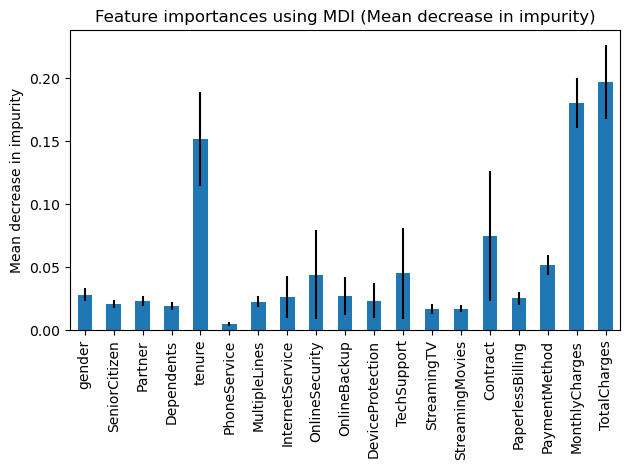

In [32]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)

feature_names = X.columns.values.tolist()

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances_mdi = pd.Series(importances, index=feature_names)

print(forest_importances_mdi.sort_values(ascending=False))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI (Mean decrease in impurity)")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Feature permutation

MonthlyCharges      0.105850
tenure              0.103748
Contract            0.100227
TotalCharges        0.099290
PaymentMethod       0.056695
TechSupport         0.048857
PaperlessBilling    0.046969
OnlineSecurity      0.045819
InternetService     0.041360
OnlineBackup        0.029845
MultipleLines       0.027332
gender              0.026906
Partner             0.023910
DeviceProtection    0.021937
SeniorCitizen       0.021397
Dependents          0.020716
StreamingMovies     0.020602
StreamingTV         0.019310
PhoneService        0.001775
dtype: float64


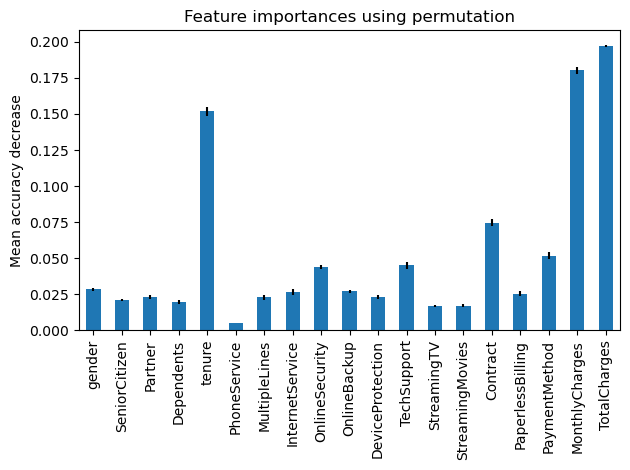

In [35]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X, y, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances_pi = pd.Series(result.importances_mean, index=feature_names)
print(forest_importances_pi.sort_values(ascending=False))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

<h1 style='color:orange'>NOTE</h1>

### Breiman (2001) Section 9:

* If the input dataset is just a combination of many "weak" (low-variance) features, a higher 'max_features' value will perform better so long as the features have low correlation.

### Probst (2018) Section 2.3:

The formula for Area Under the Curve of a Random Forest for binary classification (either 1 or 0) is:

$AUC = \frac{\sum_{i=1}^{n_1} \sum_{j=1}^{n_2} S(\hat{p}_i^*,\hat{p}_j^{**})}{n_1n_2}$

* $n_1 =$ The number of observations whose class is predicted to be 1
* $n_2 =$ The number of observations whose class is predicted to be 0
* $\hat{p}_{i}^*=$ The number of trees that predicted 1 for the $n_1^{th}$ instance divided by the number of trees in the forest
* $\hat{p}_{j}^{**}=$ The number of trees that predicted 1 for the $n_2^{th}$ instance divided by the number of trees in the forest

$S(\hat{p}_i^*,\hat{p}_j^{**}) =$ A function that returns the following:

* If $(\hat{p}_i^* < \hat{p}_j^{**})$, return 0.0
* If $(\hat{p}_i^* = \hat{p}_j^{**})$, return 0.5
* If $(\hat{p}_i^* > \hat{p}_j^{**})$, return 1.0

The larger this value, the better the classifier is.

Unsure if this is what's implemented by sklearn.

In [4]:
## Model
## TODO: Define some methods that calculate and display the different measures of convergence (Accuracy, AUC, ROC)

class RFC:
    '''
    Parameters:
      * X = A pandas.DataFrame of features
      * y = An associative (same index as X) pandas.Series of labels
      * hyperParameters = A dict whose keys correspond to the parameters of
        RandomForestClassifer and whose values are lists of arguments for those
        parameters
      * refit = The name of the sklearn.metrics scoring function to use to
        ultimately rank classifiers:
          - 'auc' = roc_auc_score
          - 'brier' = brier_score_loss
          - 'accuracy' = accuracy_score
      * cvFolds = The number of k-folds to use in cross-validation
    Other notes:
      * Research paper references throughout this class are done in this manner:
         - Breiman (2001) = B
         - Probst  (2018) = P
        Section and subsection numbers will be added after these aliases like
        B2.1 to show that a comment refers to Breiman (2001) Section 2 Subsection 1
    '''
    def __init__(self, X, y, hyperParameters={}, refit='auc', cvFolds=5):
        self.X = X
        self.y = y
        hyperParams = \
            self.__getDefaultParams__() if len(hyperParameters) == 0 else self.__validateParams__(hyperParameters)
        self.clf = self.__setupGrid__(refit, hyperParams, cvFolds)
        
    def fit(self):
        self.clf.fit(self.X, self.y)
    
    def __setupGrid__(self, refit, hyperParams, folds):
        ''' Sets up and returns a GridSearchCV object to tune the parameters
            of a RandomForestClassifier
        '''
        VALID = ['auc', 'brier', 'accuracy']
        if not refit in VALID:
            raise ValueError("refit must equal one of these three values: 'auc', 'brier', or 'accuracy'")
        ''' P5.1
            Suggests AUC, Brier, and Log Loss(for regression) are all better metrics to judge
            convergence on than the accuracy.
        '''
        scoring = {
            'auc': skm.make_scorer(skm.roc_auc_score, needs_threshold=True),
            'brier': skm.make_scorer(skm.brier_score_loss, greater_is_better=False, needs_proba=True, pos_label=1),
            'accuracy': skm.make_scorer(skm.accuracy_score)}
        return GridSearchCV(
            RandomForestClassifier(),
            param_grid = hyperParams,
            scoring = scoring,
            n_jobs = -1,
            refit = refit,
            cv = folds,
            verbose = 3,
            pre_dispatch = 4,
            return_train_score = True)
    
    def __getDefaultParams__(self):
        ''' Supplies default parameters to test based on what our source papers
            suggest are generally good.
        '''
        out = {}
        ''' B4
            Suggests selecting more than 1 features to split a node with
            doesn't perform any better than selecting 1 so long as we have a high
            number of trees.
            
            sklearn sets its default 'max_features'='sqrt', so this is added as one of
            our defaults to investigate why.  Did they find that 'sqrt' performs better
            than Breiman's suggested 1?
        '''
        out['max_features'] = [1, 'sqrt']
        ''' P5.3
            Suggests that the biggest performance gain is experienced by the first 100
            trees.  However, lower 'max_samples' values, lower 'max_depth' values, and
            higher 'max_features' values reduce inter-tree correlation and therefore
            increase the number of trees needed to reach convergence.
        '''
        out['max_depth'] = [None, 3]
        out['n_estimators'] = [100, 200]
        ''' B3
            Suggests each bootstrap sample should ideally have 2/3s of N, the length of X.
        '''
        out['max_samples'] = [float(2/3)]
        
        out['oob_score'] = [True]
        out['n_jobs'] = [-1]
        return out

    def __validateParams__(self, params):
        ''' Removes any misspelled or non-existent-in-RandomForestClassifier
            parameter name keys from the dict passed in by the caller.
        '''
        VALID = ['n_estimators', 'criterion', 'max_depth', 'min_samples_split',
                 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features',
                 'max_leaf_nodes', 'min_impurity_decrease', 'boostrap',
                 'oob_score','n_jobs', 'random_state', 'verbose', 'warm_start',
                 'class_weight', 'ccp_alpha', 'max_samples']
        invalidKeys = []
        for key in params:
            if key not in valid:
                params.pop(key)
                invalidKeys += [key]
        if len(invalidKeys) > 0:
            print("These are not valid RandomForestClassifier parameter names: {}\n".format(invalidKeys) + \
                  "They will not be tuned by GridSearchCV")
        return params if len(params) > 0 else self.__getDefaultParams__()
    

## Testing
X = df.drop("Churn", axis=1)
y = df["Churn"]
rfc = RFC(X, y)
rfc.fit()
print(rfc.clf.best_estimator_)
pd.DataFrame.from_dict(rfc.clf.cv_results_).loc[:, ['params','rank_test_auc', 'rank_test_brier', 'rank_test_accuracy']]

Fitting 5 folds for each of 8 candidates, totalling 40 fits
RandomForestClassifier(max_depth=3, max_samples=0.6666666666666666,
                       n_estimators=200, n_jobs=-1, oob_score=True)


,params,rank_test_auc,rank_test_brier,rank_test_accuracy
0,"{'max_depth': None, 'max_features': 1, 'max_sa...",8,4,3
1,"{'max_depth': None, 'max_features': 1, 'max_sa...",7,3,4
2,"{'max_depth': None, 'max_features': 'sqrt', 'm...",6,2,2
3,"{'max_depth': None, 'max_features': 'sqrt', 'm...",5,1,1
4,"{'max_depth': 3, 'max_features': 1, 'max_sampl...",4,7,7
5,"{'max_depth': 3, 'max_features': 1, 'max_sampl...",3,8,8
6,"{'max_depth': 3, 'max_features': 'sqrt', 'max_...",2,6,6
7,"{'max_depth': 3, 'max_features': 'sqrt', 'max_...",1,5,5


In [5]:
## Metrics

# Confusion Matrix
cf = skm.confusion_matrix(y_pred,y_test)
sns.heatmap(cf/np.sum(cf), fmt='.2%', annot=True, cmap='Blues')

# Classification Report
print(skm.classification_report(y_pred, y_test))

NameError: name 'y_pred' is not defined